In [1]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle
from multiprocessing import Pool
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline

In [78]:
tiles = [{'name': "Port Au Prince",   'quad': '032211203001'},#     'data': pap_users},
         {'name': "West Bucharest", 'quad': '120322103020'},#     'data': romania_users},
         {'name': "Washington DC",           'quad': '032010032232'},#     'data': dc_users},
         {'name': "Adelaide",     'quad': '311220303000'},#     'data': aus_users}
        ]

In [3]:
def reset_cursor():
    d = "dbname=osm-quality-full user=anderstj host=127.0.0.1"
    conn = psycopg2.pool.PersistentConnectionPool(1, 25, dsn=d)
    return conn.getconn().cursor(cursor_factory = psycopg2.extras.DictCursor)

### Quality Assurance: These sums should match up across the tiles and the individual users for every year.

In [4]:
CURSOR = reset_cursor()
CURSOR.execute('select year, sum(new_road_km), sum(new_buildings), sum(new_amenities), sum(new_objects),\
                sum(edited_road_km), sum(edited_buildings), sum(edited_amenities), sum(edited_objects) \
                from tiles_per_year group by year order by year')
CURSOR.fetchall()

[[2005, 0.0, 0, 0, 17121, 0.0, 0, 0, 0],
 [2006, 66081.0, 160, 11710, 5637218, 0.0, 0, 0, 0],
 [2007, 9497830.0, 11427, 79886, 179710988, 570872.0, 7894, 24499, 2005407],
 [2008,
  3191510.0,
  289749,
  289426,
  60120547,
  3116120.0,
  202932,
  168599,
  12241179],
 [2009,
  2193200.0,
  2891703,
  1148689,
  24193233,
  5425100.0,
  874002,
  410895,
  20049994],
 [2010,
  2382670.0,
  21270780,
  747514,
  49170632,
  7899800.0,
  2172201,
  686888,
  26955958],
 [2011,
  4164440.0,
  14650737,
  1041855,
  45017727,
  7482980.0,
  13027026,
  698660,
  37639138],
 [2012,
  4395810.0,
  23371955,
  1117854,
  54845153,
  10698700.0,
  6039662,
  880815,
  43305208],
 [2013,
  4182250.0,
  26629259,
  1080899,
  58297480,
  11794600.0,
  6921046,
  911608,
  58283164],
 [2014,
  4091210.0,
  35835771,
  1184351,
  80382230,
  10740900.0,
  8662961,
  1029744,
  66167067],
 [2015,
  3706450.0,
  34872748,
  1254466,
  67910141,
  11077200.0,
  8923432,
  1132694,
  61167949],
 [201

In [ ]:
CURSOR.execute('select year, sum(new_road_km), sum(new_buildings), sum(new_amenities), sum(new_objects),\
                sum(edited_road_km), sum(edited_buildings), sum(edited_amenities), sum(edited_objects) \
from users_per_tile_per_year group by year order by year')
CURSOR.fetchall()

## Using the `tiles_per_year` Table, we can sort by year and get stages of growth (general comparisons per year)

Port Au Prince
West Bucharest
Washington DC
Adelaide


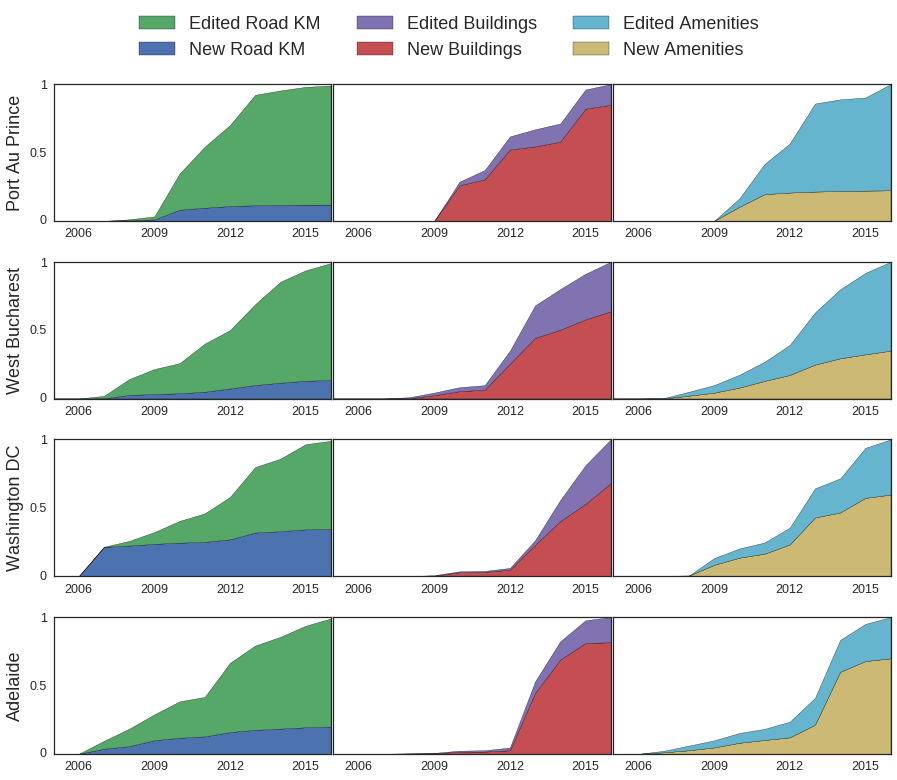

In [89]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')

prop_iter = iter(plt.rcParams['axes.prop_cycle'])
colors = [next(prop_iter)['color'] for i in range(6)]

CURSOR = reset_cursor()
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.01, hspace=0.3)

axes = list(axs.ravel())
ax_idx = 0;

for idx, tile in enumerate(tiles):
    print(tile['name'])
    CURSOR.execute("SELECT * \
        FROM tiles_per_year WHERE quadkey = %s \
        order by year",(tile['quad'],))
    
    data = OrderedDict((2005+i,[0,0,0,0,0,0,0,0]) for i in range(12))
        
    for row in CURSOR:
        # print(row)

        # Get totals, but don't use them
        annual_total_road_km   = row['edited_road_km']   + row['new_road_km']
        annual_total_buildings = row['edited_buildings'] + row['new_buildings']
        annual_total_amenities = row['edited_amenities'] + row['new_amenities']
        annual_total_objects   = row['edited_objects']   + row['new_objects']

        data[row['year']][0]     = row['new_road_km']      # / annual_total_road_km
        data[row['year']][1]     = row['edited_road_km']   # / annual_total_road_km

        data[row['year']][2]     = row['new_buildings']    # / annual_total_buildings
        data[row['year']][3]     = row['edited_buildings'] # / annual_total_buildings
        
        data[row['year']][4]     = row['new_amenities']    # / annual_total_buildings
        data[row['year']][5]     = row['edited_amenities'] # / annual_total_buildings

#     road_ax = ax.twinx()
#     road_ax.set_ylabel("Kilometers of Road")

    total_roads     = sum([x[0] for x in data.values()]) + sum([x[1] for x in data.values()])
    total_buildings = sum([x[2] for x in data.values()]) + sum([x[3] for x in data.values()])
    total_amenities = sum([x[4] for x in data.values()]) + sum([x[5] for x in data.values()])
    
    
    norm_new_km = [ x[0]/total_roads for x in data.values() ]
    norm_ed_km  = [ x[1]/total_roads for x in data.values() ]
    
    norm_new_b = [ x[2]/total_buildings for x in data.values() ]
    norm_ed_b  = [ x[3]/total_buildings for x in data.values() ]
    
    norm_new_a = [ x[4]/total_amenities for x in data.values() ]
    norm_ed_a  = [ x[5]/total_amenities for x in data.values() ]
    

    X = [x for x in list(data.keys())]

#     X1 = [x-0.5 for x in list(data.keys())]
#     km = ax.bar(X1, np.cumsum(norm_new_km), width=0.2, label='New KM', color=colors[0])
#     ed_km = ax.bar(X1, np.cumsum(norm_ed_km), bottom=np.cumsum(norm_new_km), width=0.2, label='Edited KM', color=colors[0], hatch="XX")

#     km,    = ax.plot(X1, np.cumsum(norm_new_km), linewidth=2, label='New KM',    color=colors[0])
#     ed_km, = ax.plot(X1, np.cumsum(norm_ed_km),  linewidth=2, label='Edited KM', color=colors[0], linestyle="--")
    
#     ax.


    axes[ax_idx].set_yticks([0,0.5,1.0])
    axes[ax_idx].set_yticklabels([0,0.5,1])
    axes[ax_idx].set_xticks([2006,2009,2012,2015])
    axes[ax_idx].set_ylim(0,1.01)

    axes[ax_idx].set_ylabel(tiles[idx]['name'], fontsize=18)
    
    km,       ed_km = axes[ax_idx].stackplot(X, np.cumsum(norm_new_km), np.cumsum(norm_ed_km), colors=[colors[0], colors[1]])    
    ax_idx += 1
    

    axes[ax_idx].set_yticks([])
    axes[ax_idx].set_xticks([2006,2009,2012,2015])
    
    buildings, ed_b = axes[ax_idx].stackplot(X, np.cumsum(norm_new_b), np.cumsum(norm_ed_b), colors=[colors[2], colors[3]])
    ax_idx += 1
    
    axes[ax_idx].set_yticks([])
    axes[ax_idx].set_xticks([2006,2009,2012,2015])
    
    
    amenities, ed_a = axes[ax_idx].stackplot(X, np.cumsum(norm_new_a), np.cumsum(norm_ed_a), colors=[colors[4], colors[5]])
    ax_idx += 1
    
    
#     X2 = [x-0.25 for x in list(data.keys())]
#     buildings = ax.bar(X2, np.cumsum(norm_new_b), width=0.2, label='New Buildings', color=colors[1])
#     ed_b = ax.(X2, np.cumsum(norm_ed_b), bottom=np.cumsum(norm_new_b), width=0.2, label='Edited Buildings', color=colors[1], hatch="XX")

#     buildings, = ax.plot(X, np.cumsum(norm_new_b), linewidth=2, label='New Buildings',    color=colors[1])
#     ed_b, = ax.plot(X,      np.cumsum(norm_ed_b),  linewidth=2, label='Edited Buildings', color=colors[1], linestyle="--")


#     X3 = list(data.keys())
#     amenities = ax.bar(X3, np.cumsum(norm_new_a), width=0.2, label='New Amenities', color=colors[2])
#     ed_a = ax.bar(X3, np.cumsum(norm_ed_a), bottom=np.cumsum(norm_new_a), width=0.2, label='Edited Amenities', color=colors[2], hatch="XX")

#     amenities, = ax.plot(X, np.cumsum(norm_new_a), linewidth=2, label='New Amenities', color=colors[2])
#     ed_a, =      ax.plot(X, np.cumsum(norm_ed_a),  linewidth=2, label='Edited Amenities', color=colors[2], linestyle="--")



    ax.set_ylabel("% Of Total")
    ax.set_title(tile['name'],fontsize=18)
    ax.set_xlim([2005, 2016])

# plt.legend(loc='best', fontsize=18)
plt.figlegend( [ed_km, km, ed_b, buildings, ed_a, amenities],
              ("Edited Road KM", "New Road KM", "Edited Buildings", "New Buildings", "Edited Amenities","New Amenities"), loc = ('upper center'), ncol=3, fontsize=18)

Port Au Prince, Haiti
West Bucharest, Romania
Washington DC
Adelaide, Australia


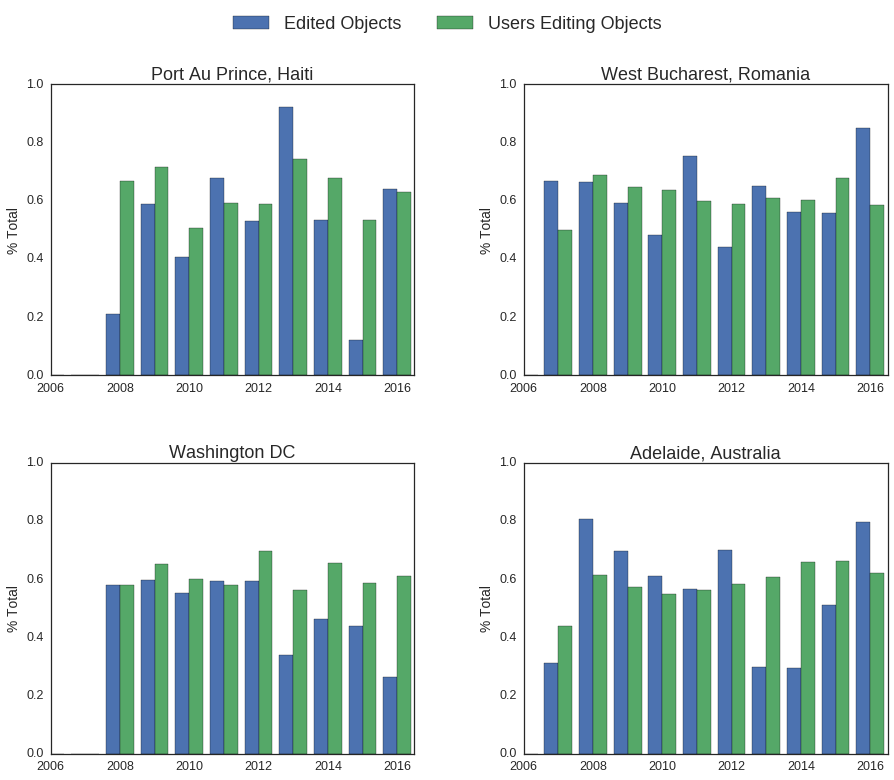

In [77]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
CURSOR = reset_cursor()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for ax, (idx, tile) in zip(axs.ravel(), enumerate(tiles)):
        
    print(tile['name'])
    CURSOR.execute("SELECT * \
        FROM tiles_per_year WHERE quadkey = %s \
        order by year",(tile['quad'],))
    
    data = OrderedDict((2005+i,[0,0,0,0]) for i in range(12))
    
    for row in CURSOR:
#         print(row)

        #Get totals
        annual_total_objects   = row['edited_objects']  +row['new_objects']
        annual_total_users     = row['users_edited_obj'] + row['users_new_obj']
        
        percent_new_obj = 0.0
        if annual_total_objects > 0:
            percent_new_obj = row['new_objects'] / annual_total_objects
        data[row['year']][0] = percent_new_obj
        data[row['year']][1] = 1-percent_new_obj
        
        percent_users_new_obj = 0.0
        if annual_total_users > 0:
            percent_users_new_obj = row['users_new_obj'] / annual_total_users
        data[row['year']][2] = percent_users_new_obj
        data[row['year']][3] = 1 - percent_users_new_obj

    X1 = [x-0.4 for x in list(data.keys())]
#     ax.bar(X1, [x[0] for x in data.values()], width=0.2, label='New Objects', color='red')
#     ax.bar(X1, [x[1] for x in data.values()], bottom=[x[0] for x in data.values()], width=0.2, label='Edited Objects', color='red', hatch="XX")
    ed_obj = ax.bar(X1, [x[1] for x in data.values()], width=0.4, color=colors[0])
    
    X2 = [x for x in list(data.keys())]
#     ax.bar(X2, [x[2] for x in data.values()], width=0.2, label='Users Creating Objects', color= 'blue')
#     ax.bar(X2, [x[3] for x in data.values()], bottom=[x[2] for x in data.values()], width=0.2, label='Users Editing Objects', color= 'blue', hatch="XX")
    ed_users = ax.bar(X2, [x[3] for x in data.values()], width=0.4, label='Users Editing Objects', color=colors[1])
   
    ax.set_ylabel("% Total")
    ax.set_xlim(2006,2016.5)
    ax.set_ylim(0,1)
    ax.set_title(tile['name'],fontsize=18)
#     X4 = [x+0.5 for x list(data.keys())]
#     plt.bar(X1, [x[3] for x in data.values(), width=0.2], label=tile['name'])
plt.figlegend( [ed_obj, ed_users],
              ('Edited Objects', 'Users Editing Objects'), loc = ('upper center'), ncol=3, fontsize=18)

In [82]:
CURSOR = reset_cursor()
CURSOR.execute("SELECT year, sum(new_objects), sum(edited_objects), sum(users_new_obj), sum(users_edited_obj) FROM \
    tiles_per_year group by year order by year")

In [83]:
res = CURSOR.fetchall()

In [84]:
res

[[2005, 17121, 0, 743, 0],
 [2006, 5637218, 0, 61754, 0],
 [2007, 179710988, 2005407, 514216, 164452],
 [2008, 60120547, 12241179, 912023, 1030631],
 [2009, 24193233, 20049994, 1331694, 2501955],
 [2010, 49170632, 26955958, 2027102, 5978056],
 [2011, 45017727, 37639138, 1582851, 6273485],
 [2012, 54845153, 43305208, 2068155, 12801068],
 [2013, 58297480, 58283164, 2205361, 20586274],
 [2014, 80382230, 66167067, 1811308, 22842122],
 [2015, 67910141, 61167949, 2048521, 20106837],
 [2016, 50421244, 28948011, 1342691, 2552116]]

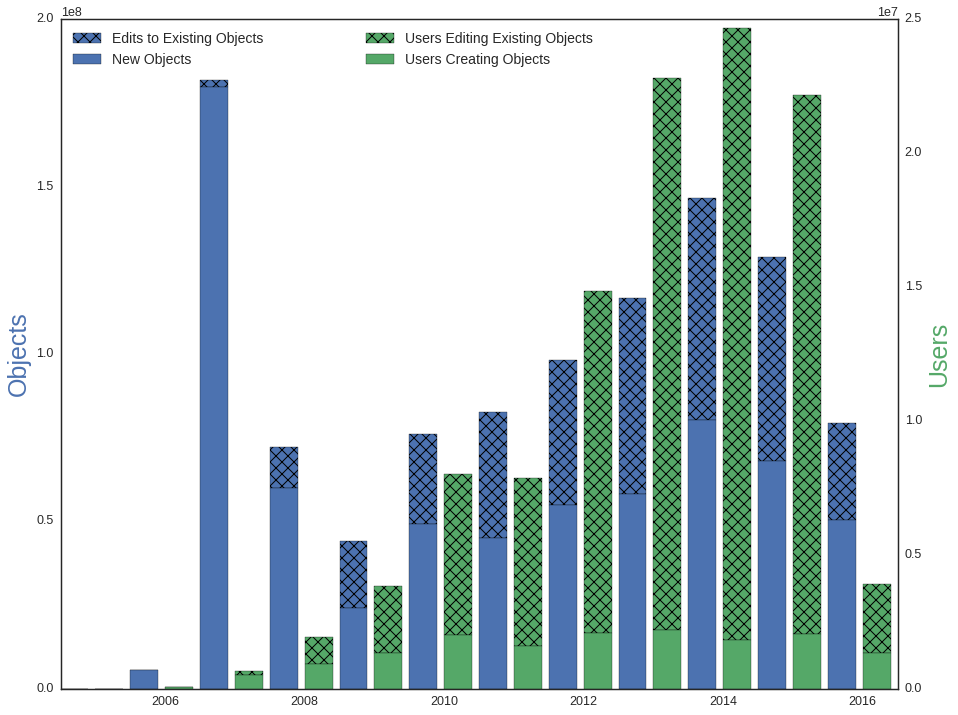

In [135]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
CURSOR = reset_cursor()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,12), facecolor='w', edgecolor='k')
        
X             = [x[0] for x in res]
new_obj       = [x[1] for x in res]
edited_obj    = [x[2] for x in res]
new_users     = [x[3] for x in res]
editing_users = [x[4] for x in res]

ax2 = ax.twinx()


X1 = [x-0.5 for x in X]

ax.bar(X1, edited_obj, bottom=new_obj, width=0.4, color=colors[0], 
       hatch="XX", label="Edits to Existing Objects")
ax.bar(X1, new_obj, width=0.4, color=colors[0], label="New Objects")

ax.set_ylabel("Objects", color=colors[0], fontsize=25)

X2 = X

ax2.bar(X2, editing_users, bottom=new_users, width=0.4,  color=colors[1], 
       hatch="XX", label="Users Editing Existing Objects")
ax2.bar(X2, new_users, width=0.4, color=colors[1], label="Users Creating Objects")

ax2.set_ylabel("Users", color=colors[1], fontsize=25)

ax.set_xlim(2004.5,2016.5)

ax.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper center', fontsize=14)

In [128]:
import plotly.plotly as py
from plotly.graph_objs import *